# About Customize Demo
Module is the core function of the BMF framework, which is the essential instance for executing logic. Users first create a BMF Graph and combine the logic of multiple Modules through serial connection to generate a description graph of the audio and video processing pipeline. When the user executes graph.Run() or graph.start(), the graph description produced by the user will be mapped as a real "executing graph" at the Engine layer. This graph is the real instance for executing the Module processing logic, which is composed of multiple Nodes combined in series, and each Node is bound to a Module instance at the bottom.

The Scheduler in the BMF Engine framework is responsible for scheduling each Node. When constructing a Module instance, the program first reads the metadata of the Module, which defines the type, path, entry, and other information of the Module. After obtaining this information, the program uses a singleton, ModuleManager, to construct the Module instance in reality (by loading it using the corresponding language's loader) and provide it to the Node for use.

For a Module, there are three methods to be implemented mustly: init(), process(), and close(). When the Node is scheduled by the Scheduler, these methods will be executed in turn until the lifecycle ends. The architecture described above can be represented by the following diagram:

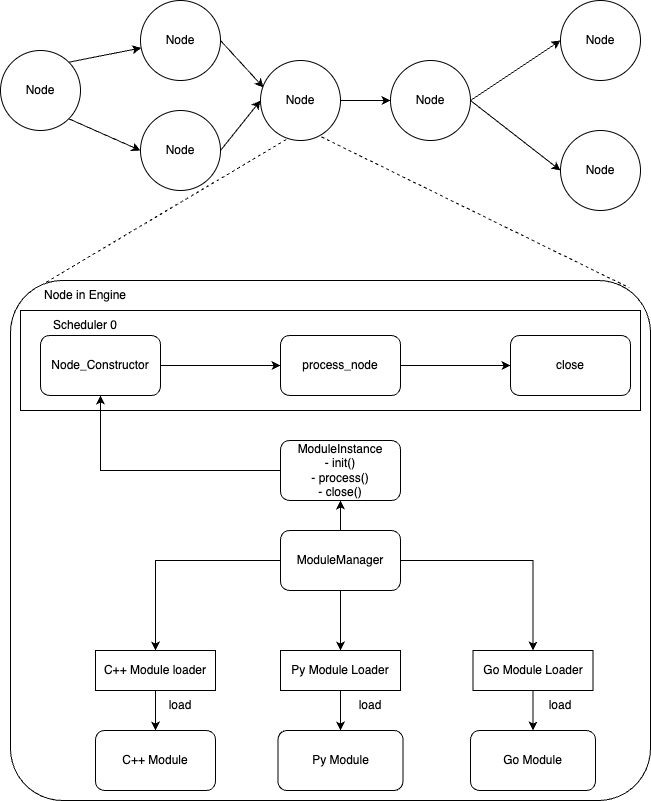

This notebook will show you how to develop Customize Python/C++ Module through the BMF framework as a module developer.Here are the codes with detailed comments:

# 1. Install BMF in Python environment.

In [ ]:
!pip install BabitMF

### Configure the environment variable to reference the BMF C library

Set necessary environment, using `bmf_env`, this step will print some necessary environment variables which is needed for c++/go development, or you intend to use the `module_manager` tool:

In [ ]:
! which bmf_env
! cat /usr/local/bin/bmf_env
! bmf_env

Copy and execute it in your terminal, in colab, we use `%env`:

In [ ]:
%env C_INCLUDE_PATH=/usr/local/lib/python3.10/dist-packages/bmf/include
%env CPLUS_INCLUDE_PATH=/usr/local/lib/python3.10/dist-packages/bmf/include
%env LIBRARY_PATH=/usr/local/cuda/lib64/stubs:/usr/local/lib/python3.10/dist-packages/bmf/lib
%env LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/lib/python3.10/dist-packages/bmf/lib

## 2.The Engine layer of the BMF framework is uniformly implemented in C++ language. In Colab, when python calls the C++ library, the log of the C++ library layer will be hidden, so it is necessary to install and load the wurlitezer library to enable logs in the C++ layer.

In [ ]:
!pip install wurlitzer
%load_ext wurlitzer

## 3. Golang is needed when you are ready to develop a go module.

In [ ]:
! apt install golang

## 4. Download a sample transcoded video from our assets (using Big Bunny as an example here).

In [ ]:
!wget https://github.com/BabitMF/bmf/releases/download/files/files.tar.gz
!tar -zvxf files.tar.gz

## 5. Write and implement Customize Module Demo
### Overall, Customize Module Demo can be decomposed into three sub-processes:
### 1. Implement the Customize Module used Python.
### 2. Implement the Customize Module used C++.
### 3. Implement the Customize Module used go.
We will analyze in detail the above two processes one by one.

### Implement the Customize Module used Python
The following code implements a simple Python module, named my_module. In the process method of my_module, it only does one thing: get a packet from the InputQueue, and then push it into the OutputQueue. Essentially, this is a pass-through module.


Create a directory named `my_python_module` to store our c++ module:

In [ ]:
! mkdir my_python_module

In [ ]:
%%writefile my_python_module/my_module.py
from bmf import Module, Log, LogLevel, InputType, ProcessResult, Packet, Timestamp, scale_av_pts, av_time_base, \
    BmfCallBackType, VideoFrame, AudioFrame


class my_module(Module):
    def __init__(self, node, option=None):
        self.node_ = node
        self.option_ = option
        pass

    def process(self, task):
        for (input_id, input_packets) in task.get_inputs().items():

            # output queue
            output_packets = task.get_outputs()[input_id]

            while not input_packets.empty():
                pkt = input_packets.get()

                # process EOS
                if pkt.timestamp == Timestamp.EOF:
                    Log.log_node(LogLevel.DEBUG, task.get_node(), "Receive EOF")
                    output_packets.put(Packet.generate_eof_packet())
                    task.timestamp = Timestamp.DONE
                    return ProcessResult.OK

                # copy input packet to output
                if pkt.defined() and pkt.timestamp != Timestamp.UNSET:
                    output_packets.put(pkt)
                    # Log.log_node(LogLevel.DEBUG, self.node_,
                    #              "process input", input_id, 'packet',
                    #              output_packets.queue[0].get_timestamp())

        return ProcessResult.OK


Install this module using `module_manager` provideed by BMF:

In [ ]:
! module_manager install my_python_module python my_module:my_module $(pwd)/my_python_module v0.0.1

You can dump the module info:

In [ ]:
! module_manager dump my_python_module

Let's implement a BMF Graph in which we use the module interface to call the my_module we just completed. We set the entry as \_\_main\_\_.my_module because all Python code runs in \_\_main\_\_ in Google Colab.

In [ ]:
import bmf
input_video_path = "./files/big_bunny_10s_30fps.mp4"
output_path = "./custom_module.mp4"

(
    bmf.graph()
        .decode({'input_path': input_video_path})['video']
        .module('my_python_module')
        .encode(None, {"output_path": output_path})
        .run()
)

### Implement the Customize Module used C++
The following code implements a simple C++ module, named cpp_copy_module. Unlike the above Python module, copy_module will make a copy of the Input Packet and then push it to the OutputQueue. Compared with my_module, copy_module will do one more copy.

To implement a C++ Module, there are several additional steps that need to be taken. First, download and install the BMF Library. Then, implement the module and CMake File separately to complete the construction of the C++ Module. Finally, a compiled product (.so) will be produced.

Create a directory named `cpp_copy_module` to store our c++ module:

In [ ]:
! mkdir cpp_copy_module

In [ ]:
%%writefile /content/cpp_copy_module/copy_module.h
#ifndef BMF_COPY_MODULE_H
#define BMF_COPY_MODULE_H

#include <bmf/sdk/bmf.h>
#include <bmf/sdk/packet.h>

USE_BMF_SDK_NS

class CopyModule : public Module
{
public:
    CopyModule(int node_id,JsonParam option) : Module(node_id,option) { }

    ~CopyModule() { }

    virtual int process(Task &task);
};

#endif


In [ ]:
%%writefile /content/cpp_copy_module/copy_module.cc
#include "copy_module.h"

int CopyModule::process(Task &task) {
    PacketQueueMap &input_queue_map = task.get_inputs();
    PacketQueueMap::iterator it;

    // process all input queues
    for (it = input_queue_map.begin(); it != input_queue_map.end(); it++) {
        // input stream label
        int label = it->first;

        // input packet queue
        Packet pkt;
        // process all packets in one input queue
        while (task.pop_packet_from_input_queue(label, pkt)) {
            // Get a input packet

            // if packet is eof, set module done
            if (pkt.timestamp() == BMF_EOF) {
                task.set_timestamp(DONE);
                task.fill_output_packet(label, Packet::generate_eof_packet());
                return 0;
            }

            // Get packet data
            // Here we should know the data type in packet
            auto vframe = pkt.get<VideoFrame>();

            // Deep copy
            VideoFrame vframe_out = VideoFrame(vframe.frame().clone());
            vframe_out.copy_props(vframe);

            // Add output frame to output queue
            auto output_pkt = Packet(vframe_out);

            task.fill_output_packet(label, output_pkt);
        }
    }
    return 0;
}
REGISTER_MODULE_CLASS(CopyModule)

In [ ]:
%%writefile /content/cpp_copy_module/CMakeLists.txt
file(GLOB SRCS *.cc *.h)

add_library(copy_module SHARED ${SRCS})
set_property(TARGET PROPERTY CXX_STANDARD 17)

# You may need this option on the version of BabitMF below 0.0.9, because the base image BMF uses for release is updated from Centos7 to AlmaLinux8
#add_definitions(-D_GLIBCXX_USE_CXX11_ABI=0)

target_link_libraries(copy_module
    PRIVATE
    bmf_module_sdk
)

set(CMAKE_INSTALL_PREFIX ${PROJECT_SOURCE_DIR})
install(TARGETS copy_module)

In [ ]:
!if [ -d build ]; then rm -rf build; fi
!cmake -DCMAKE_CXX_STANDARD=17 -B build -S cpp_copy_module
!cmake --build build
!cmake --install build

In [ ]:
!stat cpp_copy_module/lib/libcopy_module.so

Installing the module using `module_manager`:

In [ ]:
! module_manager install cpp_copy_module c++ libcopy_module:CopyModule $(pwd)/cpp_copy_module/lib v0.0.1

In [ ]:
import bmf
input_video_path = "./files/big_bunny_10s_30fps.mp4"
output_path = "./custom_module_c.mp4"

# decode
video = bmf.graph().decode({'input_path': input_video_path})
# c module processing
video_2 = (
    video['video'].c_module("cpp_copy_module")
)

# encode
(
    bmf.encode(
        video_2,  # video stream, set to None
        video['audio'],
        {"output_path": output_path,
          "video_params": {
              "vsync": "vfr",
              "max_fr": 60
          },
          "audio_params": {"codec": "aac"}
          }
    ).run()
)

### Implement the Customize Module used go
The following code implements a simple go module, named pass_through. like c++, pass_through will make a copy of the Input Packet and then push it to the OutputQueue. Compared with my_module, copy_module will do one more copy.

To implement a go Module, there are several additional steps that need to be taken. First, download and install the BMF Library. Then, implement the module and a compiled product (.so) will be produced.

Create a directory named `pass_through_module` to store our go module, and `pass_through_module/lib` to store the .so file:

In [ ]:
! mkdir -p pass_through_module/lib

In [ ]:
%%writefile pass_through_module/pass_through.go

package main

import "C"
import (
        "encoding/json"
        "errors"
        "fmt"

        "github.com/babitmf/bmf-gosdk/bmf"
)

type PassThroughModuleOption struct {
        Value int32
}

type PassThroughModule struct {
        nodeId int32
        option PassThroughModuleOption
}

func (self *PassThroughModule) Process(task *bmf.Task) error {
        fmt.Println("Go-PassThrough process-in")
        defer fmt.Println("Go-PassThrough process-out")
        iids := task.GetInputStreamIds()
        oids := task.GetOutputStreamIds()

        gotEof := false
        for i, iid := range iids {
                for pkt, err := task.PopPacketFromInputQueue(iid); err == nil; {
                        defer pkt.Free()
                        if ok := task.FillOutputPacket(oids[i], pkt); !ok {
                                return errors.New("Fill output queue failed")
                        }

                        if pkt.Timestamp() == bmf.EOF {
                                gotEof = true
                        }

                        pkt, err = task.PopPacketFromInputQueue(iid)
                }
        }

        if gotEof {
                task.SetTimestamp(bmf.DONE)
        }
        return nil
}

func (self *PassThroughModule) Init() error {
        return nil
}

func (self *PassThroughModule) Reset() error {
        return errors.New("Reset is not supported")
}

func (self *PassThroughModule) Close() error {
        return nil
}

func (self *PassThroughModule) GetModuleInfo() (interface{}, error) {
        info := map[string]string{
                "NodeId": fmt.Sprintf("%d", self.nodeId),
        }

        return info, nil
}

func (self *PassThroughModule) NeedHungryCheck(istreamId int32) (bool, error) {
        return true, nil
}

func (self *PassThroughModule) IsHungry(istreamId int32) (bool, error) {
        return true, nil
}

func (self *PassThroughModule) IsInfinity() (bool, error) {
        return true, nil
}

func NewPassThroughModule(nodeId int32, option []byte) (bmf.Module, error) {
        m := &PassThroughModule{}
        err := json.Unmarshal(option, &m.option)
        if err != nil {
                return nil, err
        }
        m.nodeId = nodeId

        return m, nil
}

func RegisterPassThroughInfo(info bmf.ModuleInfo) {
        info.SetModuleDescription("Go PassThrough description")
        tag := bmf.NewModuleTag(bmf.BMF_TAG_UTILS|bmf.BMF_TAG_VIDEO_PROCESSOR)
        info.SetModuleTag(tag)
}

//export ConstructorRegister
func ConstructorRegister() {
        bmf.RegisterModuleConstructor("go_pass_through", NewPassThroughModule, RegisterPassThroughInfo)
}

func main() {}

In [ ]:
! go mod init test
! go mod tidy
! go build -buildmode c-shared -o pass_through_module/lib/go_pass_through.so pass_through_module/pass_through.go

Installing the module using `module_manager`:

In [ ]:
! module_manager install go_pass_through go go_pass_through:PassThrough $(pwd)/pass_through_module/lib v0.0.1

In [ ]:
import bmf
input_video_path = "./files/big_bunny_10s_30fps.mp4"
output_path = "./custom_module_go.mp4"

# decode
video = bmf.graph().decode({'input_path': input_video_path})
# c module processing
video_2 = (
    video['video'].go_module("go_pass_through")
)

# encode
(
    bmf.encode(
        video_2,  # video stream, set to None
        video['audio'],
        {"output_path": output_path,
          "video_params": {
              "vsync": "vfr",
              "max_fr": 60
          },
          "audio_params": {"codec": "aac"}
          }
    ).run()
)

## 6. Display the video streams before and after processing.

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 800):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return f"""
  <video width={video_width} controls>
    <source src="{video_url}">
  </video>
  """

video_url1 = show_video('./files/big_bunny_10s_30fps.mp4')
video_url2 = show_video('custom_module.mp4')
video_url3 = show_video('custom_module_c.mp4')
video_url4 = show_video('custom_module_go.mp4')

html = video_url1 + video_url2 + video_url3 + video_url4
HTML(html)